In [1]:
#Long Short-Term Memory (LSTM)
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

In [3]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        H, C = H_C
        
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
        
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
        
        C = F * C + I * C_tilde
        
        H = O * torch.tanh(C)
        
        outputs.append(H)
    return outputs, (H, C)

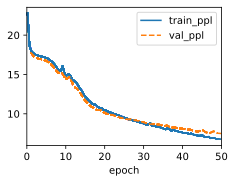

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [5]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a mation the the th'

In [6]:
model.predict('the tim', 20, data.vocab)

'the time the the the the th'

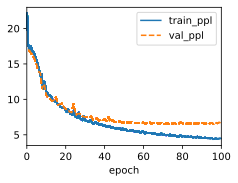

In [10]:
#Concise Implementation
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [11]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has all the time travel'

In [12]:
model.predict('the tim', 20, data.vocab)

'the time the precent in the'

In [13]:
#Gated Recurrent Units (GRU)
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

In [14]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) + torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) + torch.matmul(H, self.W_hr) + self.b_r)
        
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

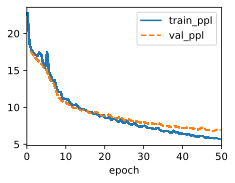

In [15]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

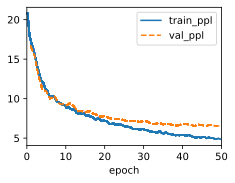

In [16]:
#Concise Implementation (GRU)
import torch
from torch import nn
from d2l import torch as d2l

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [17]:
model.predict('it has', 100, data.vocab)

'it has i the time traveller a mover the time traveller a mover the time traveller a mover the time travell'

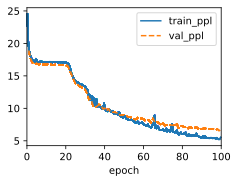

In [18]:
#Deep Recurrent Neural Networks
import torch
from torch import nn
from d2l import torch as d2l

class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])

@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNNScratch(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [19]:
model.predict('Once upon a time', 100, data.vocab)

'<unk>nce upon a time traveller and and the time traveller and and the time traveller and and the time traveller and and '

In [22]:
model.predict('it has', 100, data.vocab)

'it has ant man so man in the time traveller and and the time traveller and and the time traveller and and '

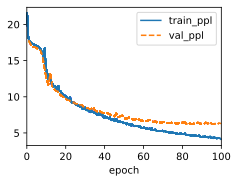

In [23]:
#Concise Implementation
class GRU(d2l.RNN):  #@save
    """The multilayer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [24]:
model.predict('it has', 100, data.vocab)

'it has have the time traveller and the time traveller and the time traveller and the time traveller and th'

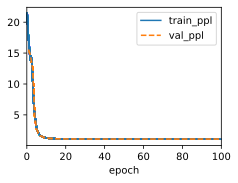

In [32]:
#Bidirectional Recurrent Neural Networks
import torch
from torch import nn
from d2l import torch as d2l

class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
BIgru = BiGRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(BIgru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [34]:
model.predict('it has', 20, data.vocab)

'it hasasasasasasasasasasas'

In [35]:
import os
import torch
from d2l import torch as d2l

In [53]:
class MTFraEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

data = MTFraEng()
raw_text = data._download()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [51]:
class MTCmnEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        d2l.extract(d2l.download('https://www.manythings.org/anki/cmn-eng.zip', self.root))
        with open(self.root + '/cmn-eng/cmn.txt', encoding='utf-8') as f:
            return f.read()

data_ch = MTCmnEng()
raw_text_ch = data_ch._download()
print(raw_text_ch[:75])

BadZipFile: File is not a zip file

In [48]:
import requests

url = "https://www.manythings.org/anki/cmn-eng.zip"
response = requests.get(url)
print(response)
# Ensure the request was successful
if response.status_code == 200:
    with open("cmn-eng.zip", "wb") as file:
        file.write(response.content)
    print("Download successful.")
else:
    print("Download failed.")


<Response [406]>
Download failed.


In [50]:
import requests

url = "https://www.manythings.org/anki/cmn-eng.zip"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    with open("cmn-eng.zip", "wb") as file:
        file.write(response.content)
    print("Download successful.")
else:
    print(f"Download failed with status code: {response.status_code}")


Download successful.


In [61]:
class MTCmnEng(d2l.DataModule):  #@save
    """The English-French dataset."""
    def _download(self):
        #d2l.extract(d2l.download('https://www.manythings.org/anki/cmn-eng.zip', self.root))
        with open(self.root + '/cmn-eng/cmn.txt', encoding='utf-8') as f:
            return f.read()

data_ch = MTCmnEng()
raw_text_ch = data_ch._download()
print(raw_text_ch[:175])

Hi.	嗨。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #891077 (Martha)
Hi.	你好。	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4857568 (musclegirlxyp)



In [71]:
@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char in ',.!?，。！？' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    return ''.join(out)

text = data._preprocess(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [72]:
text_ch = data._preprocess(raw_text_ch)
print(text_ch[:180])

hi .	嗨 。	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #891077 (martha)
hi .	你好 。	cc-by 2 .0 (france) attribution: tatoeba .org #538123 (cm) & #4857568 (musclegirlxy


In [73]:
@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) >= 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

src, tgt = data._tokenize(text)
src[:16], tgt[:16]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>'],
  ['fire', '!', '<eos>'],
  ['help', '!', '<eos>'],
  ['jump', '.', '<eos>'],
  ['stop', '!', '<eos>'],
  ['stop', '!', '<eos>'],
  ['stop', '!', '<eos>'],
  ['wait', '!', '<eos>'],
  ['wait', '!', '<eos>'],
  ['go', 'on', '.', '<eos>'],
  ['go', 'on', '.', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>'],
  ['au', 'feu', '!', '<eos>'],
  ['à', "l'aide", '!', '<eos>'],
  ['saute', '.', '<eos>'],
  ['ça', 'suffit', '!', '<eos>'],
  ['stop', '!', '<eos>'],
  ['arrête-toi', '!', '<eos>'],
  ['attends', '!', '<eos>'],
  ['attendez', '!', '<eos>'],
  ['poursuis', '.', '<eos>'],
  ['continuez', '.', '<eos>']])

In [78]:
src_ch, tgt_ch = data._tokenize(text_ch)
src_ch[:16], tgt_ch[:1600]

([['hi', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '.', '<eos>'],
  ['stop', '!', '<eos>'],
  ['wait', '!', '<eos>'],
  ['wait', '!', '<eos>'],
  ['begin', '.', '<eos>'],
  ['hello', '!', '<eos>'],
  ['i', 'try', '.', '<eos>'],
  ['i', 'won', '!', '<eos>'],
  ['oh', 'no', '!', '<eos>'],
  ['cheers', '!', '<eos>'],
  ['got', 'it', '?', '<eos>'],
  ['got', 'it', '?', '<eos>'],
  ['got', 'it', '?', '<eos>'],
  ['he', 'ran', '.', '<eos>']],
 [['嗨', '。', '<eos>'],
  ['你好', '。', '<eos>'],
  ['你用跑的', '。', '<eos>'],
  ['住手', '！', '<eos>'],
  ['等等', '！', '<eos>'],
  ['等一下', '！', '<eos>'],
  ['开始', '！', '<eos>'],
  ['你好', '。', '<eos>'],
  ['我试试', '。', '<eos>'],
  ['我赢了', '。', '<eos>'],
  ['不会吧', '。', '<eos>'],
  ['乾杯', '!', '<eos>'],
  ['知道了没有', '？', '<eos>'],
  ['懂了吗', '？', '<eos>'],
  ['你懂了吗', '？', '<eos>'],
  ['他跑了', '。', '<eos>'],
  ['跳进来', '。', '<eos>'],
  ['我知道', '。', '<eos>'],
  ['我退出', '。', '<eos>'],
  ['我不干了', '。', '<eos>'],
  ['我沒事', '。', '<eos>'],
  ['我已经起来了', '。', '<eos>'],
  

In [75]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)


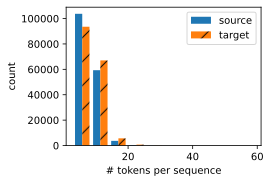

In [76]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', src, tgt);

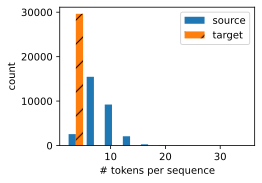

In [77]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence', 'count', src_ch, tgt_ch);

In [79]:
@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(self._download())

@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
            
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=2)
            
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
        return array, vocab, valid_len
        
    src, tgt = self._tokenize(self._preprocess(raw_text), self.num_train + self.num_val)
    
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
    
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]), src_vocab, tgt_vocab)

In [80]:
@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader(self.arrays, train, idx)

In [100]:
data = MTFraEng(batch_size=3)
print(len(data.src_vocab))
print(len(data.tgt_vocab))
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))

194
214
source: tensor([[59, 13,  2,  3,  4,  4,  4,  4,  4],
        [84, 61, 91,  2,  3,  4,  4,  4,  4],
        [92,  5,  2,  3,  4,  4,  4,  4,  4]], dtype=torch.int32)
decoder input: tensor([[  3,  66,   0,   4,   5,   5,   5,   5,   5],
        [  3, 105,  51,   2,   4,   5,   5,   5,   5],
        [  3,  37,  32,   2,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 5, 4], dtype=torch.int32)
label: tensor([[ 66,   0,   4,   5,   5,   5,   5,   5,   5],
        [105,  51,   2,   4,   5,   5,   5,   5,   5],
        [ 37,  32,   2,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [98]:
@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    
    arrays, _, _ = self._build_arrays(raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

src, tgt, src_vocab,  tgt_vocab = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))
print(src_vocab)
print(tgt_vocab.shape)

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
tensor([3])
tensor([[176,   2,   4,   5,   5,   5,   5,   5,   5]])


In [108]:
src, tgt, src_valid_len, label = next(iter(data.train_dataloader()))
for i in range (0, len(src)):
    print('source:', data.src_vocab.to_tokens(src[i].type(torch.int32)))
    print('target:', data.tgt_vocab.to_tokens(tgt[i].type(torch.int32)))

source: ['she', 'came', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'elle', 'est', '<unk>', '.', '<eos>', '<pad>', '<pad>', '<pad>']
source: ["i'm", 'well', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'je', 'vais', 'bien', '.', '<eos>', '<pad>', '<pad>', '<pad>']
source: ["i'm", 'busy', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'je', 'suis', 'occupé', '.', '<eos>', '<pad>', '<pad>', '<pad>']


In [109]:
from torch import nn
from d2l import torch as d2l

class Encoder(nn.Module):  #@save
    """The base encoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError
        
class Decoder(nn.Module):  #@save
    """The base decoder interface for the encoder--decoder architecture."""
    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

class EncoderDecoder(d2l.Classifier):  #@save
    """The base class for the encoder--decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_all_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]
        


In [110]:
#Sequence-to-Sequence Learning for Machine Translation
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [123]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    print(type(module))
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(d2l.Encoder):  #@save
    """The RNN encoder for sequence-to-sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [126]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
print(encoder)

X = torch.zeros((batch_size, num_steps))
print(X.shape)
enc_outputs, enc_state = encoder(X)

#9.5 check_len && check_shape
d2l.check_shape(enc_outputs, (num_steps, batch_size, num_hiddens))
print(enc_outputs.shape)

d2l.check_shape(enc_state, (num_layers, batch_size, num_hiddens))
print(enc_state.shape)

<class 'torch.nn.modules.sparse.Embedding'>
<class 'torch.nn.modules.rnn.GRU'>
<class 'd2l.torch.GRU'>
<class '__main__.Seq2SeqEncoder'>
Seq2SeqEncoder(
  (embedding): Embedding(10, 8)
  (rnn): GRU(
    (rnn): GRU(8, 16, num_layers=2)
  )
)
torch.Size([4, 9])
torch.Size([9, 4, 16])
torch.Size([2, 4, 16])


In [129]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        print(enc_output.shape)
        print(hidden_state.shape)
        
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        print(context.shape)
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        print(context.shape)
        
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        print(outputs.shape)
        
        outputs = self.dense(outputs).swapaxes(0, 1)
        print(outputs.shape)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        
        return outputs, [enc_output, hidden_state]

In [130]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))

<class 'torch.nn.modules.sparse.Embedding'>
<class 'torch.nn.modules.rnn.GRU'>
<class 'd2l.torch.GRU'>
<class 'torch.nn.modules.linear.LazyLinear'>
<class '__main__.Seq2SeqDecoder'>
torch.Size([9, 4, 16])
torch.Size([2, 4, 16])
torch.Size([4, 16])
torch.Size([9, 4, 16])
torch.Size([9, 4, 16])
torch.Size([4, 9, 10])


In [131]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [132]:
@d2l.add_to_class(Seq2Seq)
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

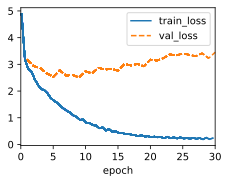

In [133]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2

encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)

decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'], lr=0.005)

trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)

trainer.fit(model, data)

In [134]:
@d2l.add_to_class(d2l.EncoderDecoder)  #@save
def predict_step(self, batch, device, num_steps, save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [135]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [136]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9, 4, 256])
torch.Size([2, 4, 256])
torch.Size([4, 256])
torch.Size([1, 4, 256])
torch.Size([1, 4, 256])
torch.Size([4, 1, 214])
torch.Size([9